In [36]:
import os
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import string
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_percentage_error as mape

In [2]:
RANDOM_SEED = 42

Импорт данных из соревнования

In [3]:
test = pd.read_csv('C:/Users/Svetamira/sf-dst-car-price-prediction/test.csv')
sample = pd.read_csv('C:/Users/Svetamira/sf-dst-car-price-prediction/sample_submission.csv')

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [5]:
test.drop('complectation_dict', axis=1) #удалим столбец с преимущественно пустыми значениями

,bodyType,brand,car_url,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,Продается BMW 316i в отличном состоянии. Прода...,1.6 LTR,136 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,...,SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,2 года и 1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,Продаётся отличный автомобиль.,2.0 LTR,190 N12,NaN,дизель,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,Хорошее состояние,2.5 LTR,170 N12,NaN,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,...,SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,https://autoru.naydex.net/nwI1K7152/b604fdsYg7...,...,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


Импорт данных с "https://www.kaggle.com/juliadeinego/data-car-sales"

In [6]:
train = pd.DataFrame()
for dirname, _, filenames in os.walk('C:/Users/Svetamira/sf-dst-car-price-prediction/data'):
    
    for filename in filenames:
        try:
            df = pd.read_csv(os.path.join(dirname, filename))        
            train = train.append(df, ignore_index = True)
        except:
            df = pd.read_csv(os.path.join(dirname, filename),sep=';')        
            train = train.append(df, ignore_index = True)
            
print(len(train))

c:\users\svetamira\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


284632


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284632 entries, 0 to 284631
Data columns (total 36 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   datetime             284071 non-null  object 
 1   parsing_unixtime     284069 non-null  float64
 2   card                 284071 non-null  object 
 3   region               284069 non-null  object 
 4   sellerName           165904 non-null  object 
 5   sell_id              284069 non-null  object 
 6   car_url              284071 non-null  object 
 7   price                284069 non-null  object 
 8   description          281468 non-null  object 
 9   image                284069 non-null  object 
 10  bodyType             284071 non-null  object 
 11  color                284071 non-null  object 
 12  engine               284069 non-null  object 
 13  engineDisplacement   284069 non-null  object 
 14  enginePower          284069 non-null  object 
 15  fuelType         

In [8]:
train.isna().sum()

datetime                  561
parsing_unixtime          563
card                      561
region                    563
sellerName             118728
sell_id                   563
car_url                   561
price                     563
description              3164
image                     563
bodyType                  561
color                     561
engine                    563
engineDisplacement        563
enginePower               563
fuelType                  563
mileage                   563
productionDate            563
vehicleTransmission       563
Владельцы                 563
ПТС                       563
Привод                    563
Руль                      563
Состояние                 563
Таможня                   563
card_type                 561
brand                     561
model_name                563
model_name2               563
name                      563
equipment_dict            563
public_date               563
nview                     563
model_name

In [9]:
train.dropna(subset=['price'], inplace=True)

In [10]:
train.isna().sum()

datetime                    0
parsing_unixtime            0
card                        0
region                      0
sellerName             118165
sell_id                     0
car_url                     0
price                       0
description              2603
image                       0
bodyType                    0
color                       0
engine                      0
engineDisplacement          0
enginePower                 0
fuelType                    0
mileage                     0
productionDate              0
vehicleTransmission         0
Владельцы                   0
ПТС                         0
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
card_type                   0
brand                       0
model_name                  0
model_name2                 0
name                        0
equipment_dict              0
public_date                 0
nview                       0
model_name

In [11]:
#посмотрим какие колонки из data_train есть в data_test

#создадим пустой список, в который добавим колонки data_train, присутствующие в data_test
in_test = []
#создадим пустой список, в который добавим колонки data_train, отсутствующие в data_test
not_in_test = []

for column in train.columns:
    if column in test.columns:
        in_test.append(column)
    else:
        not_in_test.append(column)

In [12]:
in_test 

['parsing_unixtime',
 'sell_id',
 'car_url',
 'description',
 'image',
 'bodyType',
 'color',
 'engineDisplacement',
 'enginePower',
 'fuelType',
 'mileage',
 'productionDate',
 'vehicleTransmission',
 'Владельцы',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня',
 'brand',
 'model_name',
 'name',
 'equipment_dict']

In [13]:
not_in_test

['datetime',
 'card',
 'region',
 'sellerName',
 'price',
 'engine',
 'card_type',
 'model_name2',
 'public_date',
 'nview',
 'model_name_full',
 'confDict',
 'dealerName']

In [14]:
columns_to_drop = not_in_test[:4] + not_in_test[5:]

In [15]:
train = train.drop(columns_to_drop, axis = 1)

In [16]:
test = test[in_test]

In [17]:
train.isna().sum()

parsing_unixtime          0
sell_id                   0
car_url                   0
price                     0
description            2603
image                     0
bodyType                  0
color                     0
engineDisplacement        0
enginePower               0
fuelType                  0
mileage                   0
productionDate            0
vehicleTransmission       0
Владельцы                 0
ПТС                       0
Привод                    0
Руль                      0
Состояние                 0
Таможня                   0
brand                     0
model_name                0
name                      0
equipment_dict            0
dtype: int64

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284069 entries, 0 to 284631
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   parsing_unixtime     284069 non-null  float64
 1   sell_id              284069 non-null  object 
 2   car_url              284069 non-null  object 
 3   price                284069 non-null  object 
 4   description          281466 non-null  object 
 5   image                284069 non-null  object 
 6   bodyType             284069 non-null  object 
 7   color                284069 non-null  object 
 8   engineDisplacement   284069 non-null  object 
 9   enginePower          284069 non-null  object 
 10  fuelType             284069 non-null  object 
 11  mileage              284069 non-null  object 
 12  productionDate       284069 non-null  float64
 13  vehicleTransmission  284069 non-null  object 
 14  Владельцы            284069 non-null  object 
 15  ПТС              

In [19]:
test.isna().sum()

parsing_unixtime          0
sell_id                   0
car_url                   0
description               0
image                     0
bodyType                  0
color                     0
engineDisplacement        0
enginePower               0
fuelType                  0
mileage                   0
productionDate            0
vehicleTransmission       0
Владельцы                 0
ПТС                       1
Привод                    0
Руль                      0
Состояние                 0
Таможня                   0
brand                     0
model_name                0
name                      0
equipment_dict         9996
dtype: int64

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   parsing_unixtime     34686 non-null  int64 
 1   sell_id              34686 non-null  int64 
 2   car_url              34686 non-null  object
 3   description          34686 non-null  object
 4   image                34686 non-null  object
 5   bodyType             34686 non-null  object
 6   color                34686 non-null  object
 7   engineDisplacement   34686 non-null  object
 8   enginePower          34686 non-null  object
 9   fuelType             34686 non-null  object
 10  mileage              34686 non-null  int64 
 11  productionDate       34686 non-null  int64 
 12  vehicleTransmission  34686 non-null  object
 13  Владельцы            34686 non-null  object
 14  ПТС                  34685 non-null  object
 15  Привод               34686 non-null  object
 16  Руль

Удалим столбцы description & equipment_dict так как там остались пустые значения        

In [21]:
train = train.drop(['description', 'equipment_dict'], axis=1)
test = test.drop(['description', 'equipment_dict'], axis=1)

Предобработка данных

Все числовые параметры изменим на числа

In [22]:
train['price'] = [''.join(re.findall("\d*\.?\d+", item)) for item in train['price']]
train['engineDisplacement'] = [''.join(re.findall("\d*\.\d+", item)) for item in train['engineDisplacement']]
train['enginePower'] = [''.join(re.findall("\d*\.?\d+", item)) for item in train['enginePower']]
train['mileage'] = [''.join(re.findall("\d*\.?\d+", item)) for item in train['mileage']]
train['Владельцы'] = [''.join(re.findall("\d*\.?\d+", item)) for item in train['Владельцы']]

test['engineDisplacement'] = [''.join(re.findall("\d*\.\d+", item)) for item in test['engineDisplacement']]
test['enginePower'] = test['enginePower'].apply(lambda x: x.replace(' N12', ''))
test['Владельцы'] = [''.join(re.findall("\d*\.?\d+", item)) for item in test['Владельцы']]

Изменим все типы данных у измененных параметров

In [23]:
train['price'] = train['price'].values.astype('int64')
train['engineDisplacement'] = train['engineDisplacement'].values.astype('float64')
train['enginePower'] = train['enginePower'].values.astype('int64')
train['mileage'] = train['mileage'].values.astype('int64')
train['Владельцы'] = train['Владельцы'].values.astype('int64')

#test['engineDisplacement'] = test['engineDisplacement'].values.astype('float64')
test['enginePower'] = test['enginePower'].values.astype('int64')
test['Владельцы'] = test['Владельцы'].values.astype('int64')

Удаляю столбцы, которые очень вряд ли на что-то влияют

In [24]:
columns_to_drop_2 = ['parsing_unixtime', 'sell_id', 'car_url', 'image', 'name', 'color', 'fuelType', 'bodyType', 'Таможня']
#удаляю либо из-за того что не нужные, либо тестовая отличается от тренировочной, либо тяжело преобразовать 
# в числовые из категориальных

In [25]:
test = test.drop(columns_to_drop_2, axis=1)
train = train.drop(columns_to_drop_2, axis=1)

test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   engineDisplacement   34686 non-null  object
 1   enginePower          34686 non-null  int64 
 2   mileage              34686 non-null  int64 
 3   productionDate       34686 non-null  int64 
 4   vehicleTransmission  34686 non-null  object
 5   Владельцы            34686 non-null  int64 
 6   ПТС                  34685 non-null  object
 7   Привод               34686 non-null  object
 8   Руль                 34686 non-null  object
 9   Состояние            34686 non-null  object
 10  brand                34686 non-null  object
 11  model_name           34686 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.2+ MB


EDA

Рассмотрим наиболее важные признаки и их зависимость от целевой переменной

In [26]:
train['log_price'] = np.log(train.price)

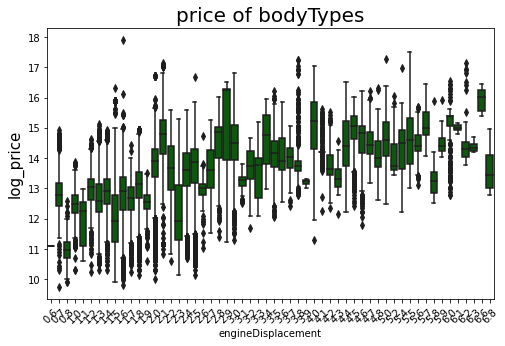

In [27]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='engineDisplacement', 
                  data=train, color='darkgreen')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

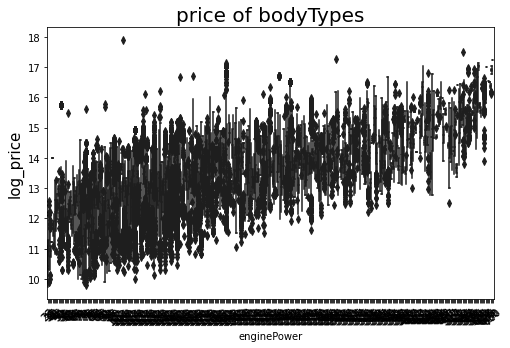

In [28]:
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='enginePower', 
                  data=train, color='darkgreen')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

Дальше смотреть на графики мне показалось не информативным, буду создавать полиномиальные признаки

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   engineDisplacement   34686 non-null  object
 1   enginePower          34686 non-null  int64 
 2   mileage              34686 non-null  int64 
 3   productionDate       34686 non-null  int64 
 4   vehicleTransmission  34686 non-null  object
 5   Владельцы            34686 non-null  int64 
 6   ПТС                  34685 non-null  object
 7   Привод               34686 non-null  object
 8   Руль                 34686 non-null  object
 9   Состояние            34686 non-null  object
 10  brand                34686 non-null  object
 11  model_name           34686 non-null  object
dtypes: int64(4), object(8)
memory usage: 3.2+ MB


In [30]:
#dummy = ['vehicleTransmission', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня']
#for col in dummy:
train['vehicleTransmission'] = pd.get_dummies(train['vehicleTransmission'])
train['ПТС'] = pd.get_dummies(train['ПТС'])
train['Привод'] = pd.get_dummies(train['Привод'])
train['Руль'] = pd.get_dummies(train['Руль'])
train['Состояние'] = pd.get_dummies(train['Состояние'])
train['brand'] = pd.get_dummies(train['brand'])
train['model_name'] = pd.get_dummies(train['model_name'])

test['vehicleTransmission'] = pd.get_dummies(test['vehicleTransmission'])
test['ПТС'] = pd.get_dummies(test['ПТС'])
test['Привод'] = pd.get_dummies(test['Привод'])
test['Руль'] = pd.get_dummies(test['Руль'])
test['Состояние'] = pd.get_dummies(test['Состояние'])
test['brand'] = pd.get_dummies(test['brand'])
test['model_name'] = pd.get_dummies(test['model_name'])


train.head(3)
test.head(3)

,engineDisplacement,enginePower,mileage,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,Состояние,brand,model_name
0,1.2,105,74000,2014,0,3,0,0,1,1,0,0
1,1.6,110,60563,2017,0,1,0,0,1,1,0,0
2,1.8,152,88000,2014,0,1,0,0,1,1,0,0


In [31]:
X = train.drop('price', axis=1)
y = train['price']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, shuffle=True, random_state=RANDOM_SEED)

In [33]:
np.log(y_train)

116948    12.779873
7311      14.062371
168145    10.463103
22847     14.316286
32570     12.206073
            ...    
120436    13.864301
259738    12.206073
132489    14.585156
147424    12.100712
122515    13.795308
Name: price, Length: 85220, dtype: float64

In [37]:
model = CatBoostRegressor(iterations = 5000, random_seed = RANDOM_SEED, eval_metric='MAPE', custom_metric=['R2', 'MAE'], silent=True, ) 
model.fit(X_train, np.log(y_train),
     eval_set=(X_test, np.log(y_test)),
     verbose_eval=0,
     use_best_model=True,
     )

predict_test = np.exp(model.predict(X_test)) 
#predict_submission = np.exp(model.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 0.42%


In [38]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))
predict_test = np.exp(gb.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 0.00%


In [39]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,) 
rfr.fit(X_train, np.log(y_train))

predict_test = np.exp(rfr.predict(X_test))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 2.60%


Вывод

У меня совсем не хватило времени качественно выполнить проект
Да и идей в голове особо нет, что и как можно улучшить
Во-первых я бОльшую часть времени потратила на то чтобы спарсить данные, но у меня ничего не получилось
И я взяла готовое решение на kaggle

Далее я пыталась разобраться с предобработкой
В EDA скорее всего надо было добавить новые признаки, на основании имеющихся данных
Но опять же время поджимало и я решила пойти по самому простому пути

В итоге получилось очень плохо, я знаю ((